# Text Preprocesing



## Installing Dependency


In [1]:
!pip install emoji
!pip install talos
!pip install symspellpy
!pip install -U spacy
!pip install -U spacy-lookups-data
#python -m spacy download zh_core_web_sm
!python -m spacy download en_core_web_lg

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.2)
Requirement already up-to-date: spacy-lookups-data in /usr/local/lib/python3.6/dist-packages (0.3.2)
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
import pandas as pd
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
import numpy as np 
import emoji
import nltk
from pathlib import Path
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from symspellpy import SymSpell, Verbosity
# text preprocessing
from nltk.tokenize import word_tokenize
import pkg_resources
import re, string, json
import spacy
from tqdm.notebook import tqdm
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import en_core_web_lg
import talos

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
seed=10
tf.random.set_seed(seed)

## DATA EXPLORATORY & CLEANING

Objective is to make the data as error-free as possible for the model to train on.
- explore the data, print out the statistics to understand the dataset composition
- Identify characters that do not contain information and does not facilitate in model training 
<br>(e.g. special symbols, special character, wrong punctuation, werid numbers, wrong spelling)
- Remove or fill empty rows with default values
- convert the dataset to lower- cased. 

### Data Exploratory

In [4]:
#reading data from csv file
df = pd.read_csv("text_emotion.csv", engine = 'python')

#print out the stats of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   author     40000 non-null  object
 3   content    40000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [5]:
#show first 5 of the dataset
df.head(5)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [6]:
#explore what are the unique sentiments that is within the dataset
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [7]:
#explore what are the unique author/username that is within the dataset
len(df['author'].unique())

33871

In [8]:
#explore what are the unique content that is within the dataset (checking for duplicates)
len(df['content'].unique())

39827

In [9]:
#check for duplication
duplicated = df[df.duplicated(['content','sentiment'])]
duplicated.head(10)

,tweet_id,sentiment,author,content
521,1957088574,worry,Chassidy7,Somebody please save the polar bears!
6591,1961366316,sadness,Zoraida1980,Headache
8878,1962332251,worry,letsdomusiccc,My throat hurts
10918,1963057544,worry,CoopInSoCal,@ericbolling Where's Dani Babb?
12531,1963597385,sadness,laurenc3191,not feeling too great today
15728,1964969733,sadness,Nickiitah,I miss you
15988,1965087416,neutral,BETTERIDGE6,going to work
17457,1965667672,neutral,Jazze820,cleaning my room
18130,1965893112,worry,EmperorCommodus,i have a headache
18472,1965978796,worry,Sw3eTiE,My back hurts


In [10]:
#show the number of unique content within each sentiments to check if there is data imbalance in each group 
data =df.drop_duplicates(subset=['content', 'sentiment'])
sentiment_count= data['sentiment'].value_counts(sort=False)
sentiment_count


boredom        179
worry         8452
hate          1323
neutral       8617
enthusiasm     759
relief        1524
love          3801
sadness       5160
anger          110
happiness     5194
fun           1776
empty          827
surprise      2187
Name: sentiment, dtype: int64

### Plot statistics of data to understand the dataset composition 
- see number of classes and samples in each class to spot any data imbalance, therefore we will be adding additional dataset from https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp to balance out the emotions
- We will be trimming the dataset to only 6 basic emotions

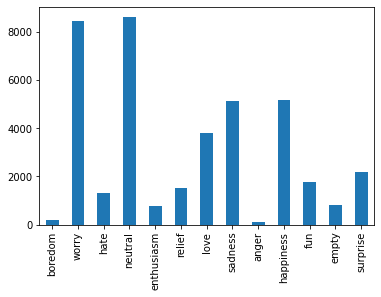

In [11]:
sentiment_count.plot.bar()

### Data cleaning 
- Remove any empty rows if any as it does not hold any value to text emotion recognition
- Normalise text datanase into lower case as un-cased characters are regarded differently by computers as different words
- -If info between the cased and un-cased chars needs to be used e.g. Named Entity Recognition (NER) task where words starting with capital letters are named entities in NER, leave the dataset as- is with case chars intact.

In [12]:
emotion_train_df = pd.read_csv('train.txt', header =None, sep =';', names = ['content','sentiment'], encoding='utf-8')
emotion_test_df = pd.read_csv('test.txt', header = None, sep =';', names = ['content','sentiment'],encoding='utf-8')
emotion_val_df = pd.read_csv('val.txt', header = None, sep =';', names = ['content','sentiment'],encoding='utf-8')

In [13]:
emotion_train_df.info()
print('\n')
emotion_val_df.info()
print('\n')
emotion_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    16000 non-null  object
 1   sentiment  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2000 non-null   object
 1   sentiment  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    2000 non-null   object
 1   sentiment  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [14]:
frame = [emotion_test_df, emotion_train_df, emotion_val_df]
new_emotion_df = pd.concat(frame)
new_emotion_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    20000 non-null  object
 1   sentiment  20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


In [15]:
new_emotion_df['sentiment'].value_counts(sort=False)

sadness     5797
anger       2709
joy         6761
love        1641
fear        2373
surprise     719
Name: sentiment, dtype: int64

In [16]:
new_emotion_df['sentiment']= new_emotion_df['sentiment'].replace(['joy'], 'happiness')
new_emotion_df['sentiment'].value_counts(sort=False)

sadness      5797
anger        2709
happiness    6761
love         1641
fear         2373
surprise      719
Name: sentiment, dtype: int64

In [17]:
# trimming of dataset to only sentiment and content
crowdflower_df = data[['content', 'sentiment']]
crowdflower_df.head()



,content,sentiment
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral


In [18]:
# display the general info of the cleaned dataset
crowdflower_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39909 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    39909 non-null  object
 1   sentiment  39909 non-null  object
dtypes: object(2)
memory usage: 935.4+ KB


In [19]:
crowdflower_df['sentiment']= crowdflower_df['sentiment'].replace(['hate'], 'anger')
crowdflower_df['sentiment'] = crowdflower_df['sentiment'].replace(['worry'], 'fear')
crowdflower_df['sentiment'].value_counts(sort=False)

boredom        179
neutral       8617
enthusiasm     759
relief        1524
love          3801
sadness       5160
anger         1433
happiness     5194
fun           1776
fear          8452
empty          827
surprise      2187
Name: sentiment, dtype: int64

In [20]:
combine_frame = [crowdflower_df, new_emotion_df]
combined_df = pd.concat(combine_frame)
combined_df['sentiment'].value_counts(sort = False)

boredom         179
relief         1524
sadness       10957
anger          4142
fun            1776
fear          10825
surprise       2906
neutral        8617
enthusiasm      759
love           5442
happiness     11955
empty           827
Name: sentiment, dtype: int64

In [21]:
combined_df[combined_df.sentiment == 'anger']

,content,sentiment
30,It is so annoying when she starts typing on he...,anger
86,dammit! hulu desktop has totally screwed up my...,anger
99,@ cayogial i wanted to come to BZ this summer ...,anger
101,@mrgenius23 You win ... SIGH Rakeem,anger
105,"@soviet_star Damn, that sucks",anger
...,...,...
1982,i feel like the world is just being bitter and...,anger
1983,i see people who have accomplished so much mor...,anger
1985,i started to see a concerning pattern i d rush...,anger
1993,i feel so tortured by it,anger


In [22]:
# trimming of dataset to only 7 major emotions.
#sadness, anger, love, happiness, surprise, fear ,neutral
dataframes = (combined_df[combined_df.sentiment == 'sadness'], combined_df[combined_df.sentiment == 'anger'], combined_df[combined_df.sentiment == 'love'], combined_df[combined_df.sentiment == 'happiness'], combined_df[combined_df.sentiment == 'surprise'], combined_df[combined_df.sentiment == 'fear'], combined_df[combined_df.sentiment == 'neutral'])
trimmed_dataset = pd.concat(dataframes)
trimmed_dataset['sentiment'].value_counts(sort = False)

sadness      10957
anger         4142
fear         10825
surprise      2906
neutral       8617
love          5442
happiness    11955
Name: sentiment, dtype: int64

In [23]:
def build_vocabulary(texts):
    """
    input: list of list of words
    output: dictionary of words and their count
    """
    print('build vocabulary')
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in tqdm(sentences):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

import operator
def check_coverage(vocab, embeddings_index):
    '''
    input: vocabulary, embedding index
    output: list of unknown words; also prints the vocabulary coverage of embeddings and the % of comments text covered by the embeddings
    '''
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in tqdm(vocab.keys()):
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass
    print('Found embeddings for {:.3%} of vocabulary'.format(len(known_words)/len(vocab)))
    print('Found embeddings for {:.3%} of all text'.format(nb_known_words/(nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]
    return unknown_words

#### Remove any duplicates of white space, punctuations and URLs:
This is done via a simple regex replace. By doing regex cleaning we will not have multiple sizes of reticence and exclamation point markings. Additionally, the removal of URL will reduce the number of distinct tokens that we have during tokenisation later

**Note: `_replace_urls` is used before `clean_punctuation` to prevent replacement of complex punctuations use within urls.**



In [24]:
def clean_regex(sentence_list):
    corrected_sentence_list = []
    print("Normalizing whitespaces and punctuation")
    for sentence in tqdm(sentence_list):
        _text = _replace_urls(sentence)
        _text = _clean_punctuation(_text)
        _text = _normalize_whitespace(_text)
        corrected_sentence_list.append(_text)
    return corrected_sentence_list

#replace any URLs with a <URL> tag
def _replace_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "<URL>", text)
    return text

# Simplifies doubled or more complex punctuation with the exception of '...'
def _clean_punctuation(text):
  
    sentence = str(text)
    #sentence = re.sub(r'[^A-Za-z0-9(),!;?\'\`\"]1+', r'\1', sentence)
    sentence = re.sub(r'([!?,;])\1+', r'\1', sentence)
    sentence = re.sub(r'\.{2,}', r'...', sentence)
    #sentence = re.sub(r"\s{2,}", ' ', sentence)
    sentence = sentence.strip()
    return sentence

# Normalizes whitespaces by removing duplicates
def _normalize_whitespace(text):
  
    sentence = str(text)
    sentence = re.sub(r"//t",r"\t", sentence)
    sentence = re.sub(r"( )\1+",r"\1", sentence)
    sentence = re.sub(r"(\n)\1+",r"\1", sentence)
    sentence = re.sub(r"(\r)\1+",r"\1", sentence)
    sentence = re.sub(r"(\t)\1+",r"\1", sentence)
    return sentence.strip(" ")
    

#### Substitution of contractions:
As data is from social media, slang and  contraction are commonly used. By using
a list of contractions from Wikipedia, we loop through the sentences and replace the contractions for their actual words. This allow for better sentence structuring for tokenization. 

In [25]:
def replace_contractions_abbervations(sentence_list):
    contraction_list = json.loads(open('english_contractions.json', 'r').read())
    abbervation_list = json.loads(open('abbervations.json', 'r').read())
    corrected_sentence_list = []
    print("Normalizing contractions")
    for sentence in tqdm(sentence_list):
        corrected_sentence = _normalize_contractions_text(sentence, contraction_list)
        corrected_sentence_list.append(_normalize_abbervations_text(corrected_sentence, abbervation_list))
    return corrected_sentence_list

# replace english contractions with actual words
def _normalize_contractions_text(text, contractions):
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

# replace abbervations with actual words
def _normalize_abbervations_text(text, abbervations):
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in abbervations:
            replacement = abbervations[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

#### Spell Correction:
Given that most spelling correcting dictionaries lack important contextual words, so consider slangs as misspells. Spelling correction is tricky as it may cauuse unwanted changes.

However, i decided to use `symspellpy` for spelling correction due to its computational efficiency. An alternatice approach is through a deep learning model to do spelling correction based on context e.g. Word2Vect


In [26]:
def spelling_correction(sentence_list):
    max_edit_distance_dictionary= 3
    prefix_length = 4
    spellchecker = SymSpell(max_edit_distance_dictionary, prefix_length)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
    bigram_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
    spellchecker.load_dictionary(dictionary_path, term_index=0, count_index=1)
    spellchecker.load_bigram_dictionary(dictionary_path, term_index=0, count_index=2)
    corrected_sentence_list = []
    print("Spell correcting")
    for sentence in tqdm(sentence_list):
        corrected_sentence_list.append(_spelling_correction_text(sentence, spellchecker))
    return corrected_sentence_list


# Spelling correction is done via pyspellchecker module. It works over a tokenized sentence and only the token representations are changed.
def _spelling_correction_text(text, spellchecker):

    if len(text) < 1:
        return ""
    #Spell checker config
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.TOP # TOP, CLOSEST, ALL
    #End of Spell checker config
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word is None:
            token_list[word_pos] = ""
            continue
        if not '\n' in word and word not in string.punctuation and not is_numeric(word) and not (word.lower() in spellchecker.words.keys()):
            suggestions = spellchecker.lookup(word.lower(), suggestion_verbosity, max_edit_distance_lookup)
            #Checks first uppercase to conserve the case.
            upperfirst = word[0].isupper()
            #Checks for correction suggestions.
            if len(suggestions) > 0:
                correction = suggestions[0].term
                replacement = correction
            #We call our _reduce_exaggerations function if no suggestion is found. Maybe there are repeated chars.
            else:
                replacement = _reduce_exaggerations(word)
            #Takes the case back to the word.
            if upperfirst:
                replacement = replacement[0].upper()+replacement[1:]
            word = replacement
            token_list[word_pos] = word
    return " ".join(token_list).strip()

"""
Auxiliary function to help with slang replacement.
Examples:
    gud -> good
    layin -> laying
"""
def _reduce_exaggerations(text):
    correction = str(text)
    #TODO work on complexity reduction.
    return correction

def is_numeric(text):
    for char in text:
        if not (char in "0123456789" or char in ",%.$"):
            return False
    return True


#### Lemmatization:
We will be using spaCy for lemmatizing the dataset. As spaCy is fast and straightforward. Hashtags and mentions are also removed during preprocessing as it does not benefit us during text emotion classification.


In [27]:
def lemmatization(sentence_list, sentiment):
    nlp = en_core_web_lg.load()
    lemmatized=[]
    i = 0
    print("Lemmatizing Sentences")
    for sentence in tqdm(sentence_list):
        lemmatized.append([_lemmatize_text(sentence, nlp).strip(), sentiment[i]])
        i+=1
    return lemmatized

def _lemmatize_text(sentence, nlp):
    sent = ""
    doc = nlp(sentence)
    for token in doc:
        if '@' in token.text:
            sent+=" @MENTION"
        elif '#' in token.text:
            sent+= " #HASHTAG"
        else:
            sent+=" "+token.lemma_
    return sent

#### Finally, we join all steps in using a “pipeline” function:

In [28]:
def normalization_pipeline(sentences, sentiment):
    print("##############################")
    print("Starting Normalization Process")
    sentences = clean_regex(sentences)
    sentences = replace_contractions_abbervations(sentences)
    sentences = spelling_correction(sentences)
    sentences = lemmatization(sentences, sentiment)
    print("Normalization Process Finished")
    print("##############################")
    return sentences

In [29]:
def train_test_datasplit(input_data):
    train_data, test_data = train_test_split(input_data, test_size=0.15)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [30]:
trimmed_dataset["sentiment"]= trimmed_dataset["sentiment"].astype('category')
print(trimmed_dataset.dtypes)
trimmed_dataset["Categorical_sentiment"]=trimmed_dataset["sentiment"].cat.codes
trimmed_dataset['Categorical_sentiment'].value_counts(sort = False)

content        object
sentiment    category
dtype: object


0     4142
1    10825
2    11955
3     5442
4     8617
5    10957
6     2906
Name: Categorical_sentiment, dtype: int64

In [31]:
normalized = normalization_pipeline(trimmed_dataset['content'].values.tolist(), trimmed_dataset['sentiment'].values.tolist())


##############################
Starting Normalization Process
Normalizing whitespaces and punctuation



Normalizing contractions



Spell correcting



Lemmatizing Sentences



Normalization Process Finished
##############################


In [32]:
from pandas import DataFrame

normalized_df = DataFrame (normalized, columns=['content', 'sentiment'])
normalized_df.head()

,content,sentiment
0,lay a bed with a headache ughhhh ... waitin on...,sadness
1,funeral ceremony ... gloomy friday ...,sadness
2,-PRON- should be sleep but -PRON- be not think...,sadness
3,@MENTION Charlene -PRON- love -PRON- miss -PRON-,sadness
4,@MENTION -PRON- be sorry at least -PRON- be Fr...,sadness


In [33]:
def train_test_split_data(input_data):
    train_data, test_data = train_test_split(input_data, test_size=0.15)
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [34]:
#convert everything to lower case
normalized_df['content']=normalized_df['content'].str.lower()

In [89]:
x_train, x_test, y_train, y_test = train_test_split(normalized_df['content'], normalized_df['sentiment'], test_size=0.2)

In [90]:
y_test.value_counts(sort=False)

sadness      2175
anger         890
happiness    2413
neutral      1709
love         1091
fear         2122
surprise      569
Name: sentiment, dtype: int64

we do normalization over via:
- Removal of duplicate whitespaces and punctuation.
- Accent removal (if your data includes diacritical marks from ‘foreign’ languages — this helps to reduce errors related to encoding type).
- Capital letter removal (often, working with lowercase words deliver better results. In some cases, however, capital letters are very important to extract information, like names and locations).
- Removal or substitution of special characters/emojis (e.g.: remove hashtags).
- Substitution of contractions (very common in English; e.g.: ‘I’m’→‘I am’).
- Transform word numerals into numbers (eg.: ‘twenty three’→‘23’).
- Substitution of values for their type (e.g.: ‘$50’→‘MONEY’).
- Acronym normalization (e.g.: ‘US’→‘United States’/‘U.S.A’) and abbreviation normalization (e.g.: ‘btw’→‘by the way’).
- Spell correction (one could say that a word can be misspelled infinite ways, so spell corrections reduce the vocabulary variation by “correcting”) — this is very important if you’re dealing with open user inputs, such as tweets, IMs and emails.
- Removal of gender/ time /grade variation with Stemming or Lemmatization.
- Stop word removal .

# 3. Text Representation
- Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))

- Tokenize with our preprocess_and_tokenize
- Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
IDF = log(# of documents / # of documents containing the word)

In [91]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

docs = map(''.join, normalized_df[['content']].values.tolist())

# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(docs)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(x_train)
X_test_vect = vect.transform(x_test)

Accuracy: 44.46%

F1 Score: 44.46

COnfusion Matrix:
 [[  16  218  263    0    4  389    0]
 [   0 1258  442    3   30  389    0]
 [   0  203 2050   19   33  108    0]
 [   0  142  757   61   15  116    0]
 [   0  700  680   11  125  193    0]
 [   0  528  261    1   18 1367    0]
 [   0  218  247    1   11   92    0]]


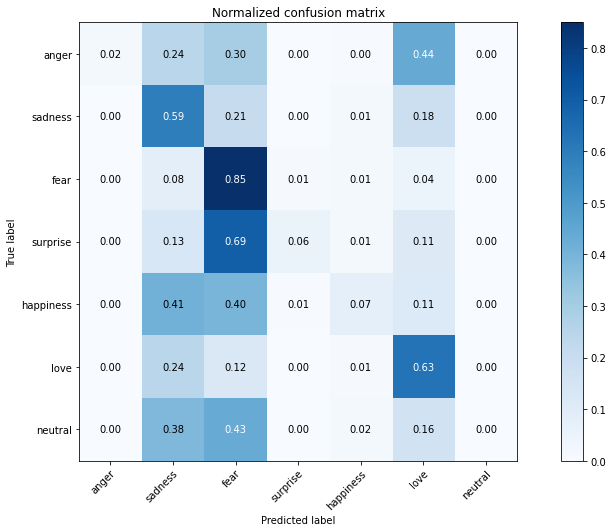

In [93]:
class_names = ['anger', 'sadness', 'fear', 'surprise', 'happiness', 'love' ,'neutral']

nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)


print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [ ]:
# save the model
filename = 'tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [ ]:
model = pickle.load(open(filename, 'rb'))

message = 'delivery was damn late and my pizza is cold!' 
model.predict([message])

## Emotion Classification in texts using CNN and Word2Vec

####Embedding Layer
Word Embedding is a representation of text where words that have the similar meaning have a similar representation. We will use 300 dimentional word vectors pre-trained on wikipedia articles. We can also train the w2v model with our data, however our dataset is quite small and trained word vectors might not be as good as using pretrained w2v.

#####Deep Network
Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data. The result of each convolution will fire when a special pattern is detected. By varying the size of the kernels and concatenating their outputs, you’re allowing yourself to detect patterns of multiples sizes (2, 3, or 5 adjacent words). Patterns could be expressions like “I hate”, “very good” and therefore CNNs can identify them in the sentence regardless of their position.

#### Fully Connected Layer
The fully connected layer takes the deep representation from the RNN/LSTM/GRU and transforms it into the final output classes or class scores. This component is comprised of fully connected layers along with batch normalization and optionally dropout layers for regularization.
Output Layer
Based on the problem at hand, this layer can have either Sigmoid for binary classification or Softmax for both binary and multi classification output.


In [95]:
# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [96]:
# Number of labels: 'anger', 'sadness', 'fear', 'surprise', 'happiness', 'love' ,'neutral'
num_classes = 7

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['anger', 'sadness', 'fear', 'surprise', 'happiness', 'love' ,'neutral']

In [97]:
def clean_text(data):
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data


texts = [' '.join(clean_text(text)) for text in normalized_df.content]

texts_train = [' '.join(clean_text(text)) for text in x_train]
texts_test = [' '.join(clean_text(text)) for text in x_test]

In [98]:
print(texts_train[92])

i feel insult but i go out with -pron- anyway


In [99]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(normalized_df.content)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 24151


In [100]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,    1,   14,  617],
       [   0,    0,    0, ...,   86,  234,  153],
       [   0,    0,    0, ...,    2,  192, 5250],
       ...,
       [   0,    0,    0, ...,    1,    2,  223],
       [   0,    0,    0, ...,    2, 2564,   95],
       [   0,    0,    0, ...,  199,    7,  671]], dtype=int32)

In [101]:
encoding = {
    'anger': 0,
    'sadness': 1,
    'fear': 2,
    'surprise': 3,
    'happiness': 4,
    'love': 5,
    'neutral': 6
}

# Integer labels
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]


In [102]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [103]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [104]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [105]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(24152, 300)

In [106]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 19668
New words found: 4483


In [107]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [ ]:
# Convolution
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
batch_size = 256
epochs = 6

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

In [ ]:
# Accuracy plot
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, predictions, average='micro') * 100))

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

#LSTM

We will attempt to use a Long Short term memory model to test the accuracy of the model.

In [115]:
def emotion_LSTM_model(x_train, y_train, x_val, y_val):
  from keras.models import Sequential
  from keras import layers
  from keras.optimizers import SGD
  from keras.regularizers import l2
  from keras.callbacks import EarlyStopping

  with tf.device('/device:GPU:0'):

    embed_dim = 128
    hidden_size = 200
    learning_rate=1.0
    num_words=24200 #our vocab size


    l2(0.1)

    model = Sequential()
    #model.add(layers.Embedding(num_words, 32)) #The embedding layer
    model.add(embedd_layer)
    model.add(layers.LSTM(80,dropout=0.2)) #Our LSTM layer
    #model.add(layers.Dense(20,activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(7,activation='softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=learning_rate),metrics = ['accuracy'])
    print(model.summary())

    batch_size = 1024
    epochs = 25

    # simple early stopping
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

    history= model.fit(x=x_train,y=y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[es],
                      validation_data=(x_val, y_val),)
  return history, model



In [116]:
LSTM_history, LSTM_model= emotion_LSTM_model(X_train_pad, y_train,X_test_pad,y_test)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          7245600   
_________________________________________________________________
lstm_8 (LSTM)                (None, 80)                121920    
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 567       
Total params: 7,368,087
Trainable params: 122,487
Non-trainable params: 7,245,600
_________________________________________________________________
None
Epoch 1/25
43/43 [==============================] - 10s 240ms/step - loss: 1.8304 - accuracy: 0.2388 - val_loss: 1.7958 - val_accuracy: 0.2525
Epoch 2/25
43/43 [==============================] - 10s 229ms/step - loss: 1.7873 - accuracy: 0.2887 - val_loss: 1.7356 - val_accuracy: 0.3275
Epoch 3/25
43/43 [==============================] - 10s 231ms/step - loss: 1.

In [ ]:
with tf.device('/device:GPU:0'):
  # Parameters
  _output_size = 128
  bidirectional = False

  # Embedding Layer, LSTM or biLSTM, Dense, softmax
  model = Sequential()
  model.add(embedd_layer)

  if bidirectional:
      model.add(Bidirectional(layers.LSTM(units=_output_size,
                                dropout=0.2,
                                recurrent_dropout=0.2)))
  else:
      model.add(layers.LSTM(units=_output_size,
                  dropout=0.2, 
                  recurrent_dropout=0.2))

  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  model.summary()

  batch_size = 128
  epochs = 10

  # simple early stopping
  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=2)

  hist = model.fit(X_train_pad, y_train, 
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es],
                  validation_data=(X_test_pad,y_test))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          7245600   
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 903       
Total params: 7,466,151
Trainable params: 220,551
Non-trainable params: 7,245,600
_________________________________________________________________
Epoch 1/10
343/343 [==============================] - 653s 2s/step - loss: 1.5603 - accuracy: 0.3988 - val_loss: 1.3780 - val_accuracy: 0.4849
Epoch 2/10
343/343 [==============================] - 640s 2s/step - loss: 1.3290 - accuracy: 0.4975 - val_loss: 1.2386 - val_accuracy: 0.5318
Epoch 3/10
343/343 [==============================] - 632s 2s/step - loss: 1.2176

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label=' training accuracy')
plt.plot(hist.history['val_accuracy'], label=' validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()


score =model.evaluate(X_test_pad, y_test, batch_size=batch_size)
print("Score of ", score)

##Talos

In [79]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

params={'lr': [1],
        'lstm_cells': [60,80,100,120],
        'dropout': [0.5,0.6,0.7,0.8],
        'l2': [1, 0.1, 0.001],
         }


def emotion_model(x_train, y_train, x_val, y_val,params):

  with tf.device('/device:GPU:0'):
    embed_dim = 128
    hidden_size = 200
    num_words=24200 #our vocab size

    learning_rate=params['lr']

    l2(params['l2'])

    model = Sequential()
    model.add(layers.Embedding(num_words, 32)) #The embedding layer
    model.add(embedd_layer)
    model.add(layers.LSTM(params['lstm_cells'],dropout=params['dropout'])) #Our LSTM layer
    model.add(layers.Dense(7,activation='softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer=SGD(learning_rate=learning_rate),metrics = ['accuracy'])
    print(model.summary())

    batch_size = 256
    epochs = 25


    # simple early stopping
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

    history= model.fit(x=x_train,y=y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[es],
                      validation_data=(x_val, y_val),)
  return history, model



In [ ]:
t= talos.Scan(x=X_train_pad,y=y_train, x_val= X_test_pad, y_val=y_test,model=emotion_model,params=params,experiment_name="Emotion experiemnt",round_limit=128)
